# Training with Offline Algorithms

[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/brainpy/brainpy/blob/master/docs_version2/tutorial_training/offline_training.ipynb)
[![Open in Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/brainpy/brainpy/blob/master/docs_version2/tutorial_training/offline_training.ipynb)

In [9]:
import brainpy.version2 as bp
import brainpy.version2.math as bm
import brainpy_datasets as bd
import matplotlib.pyplot as plt

bm.set_environment(x64=True, mode=bm.batching_mode)
bm.set_platform('cpu')

bp.__version__

'3.0.0'

BrainPy provides many offline training algorithms can help users train models such as reservoir computing models.

## Train a reservoir model

Here, we train an echo-state machine to predict chaotic dynamics. This example is used to illustrate how to use ``brainpy.train.OfflineTrainer``.

We first get the training dataset.

In [10]:
def get_subset(data, start, end):
  res = {'x': data.xs[start: end],
         'y': data.ys[start: end],
         'z': data.zs[start: end]}
  res = bm.hstack([res['x'], res['y'], res['z']])
  # Training data must have batch size, here the batch is 1
  return res.reshape((1, ) + res.shape)

In [11]:
dt = 0.01
t_warmup, t_train, t_test = 5., 100., 50.  # ms
num_warmup, num_train, num_test = int(t_warmup/dt), int(t_train/dt), int(t_test/dt)

In [12]:
lorenz_series = bd.chaos.LorenzEq(t_warmup + t_train + t_test,
                                  dt=dt,
                                  inits={'x': 17.67715816276679,
                                         'y': 12.931379185960404,
                                         'z': 43.91404334248268})

In [13]:
X_warmup = get_subset(lorenz_series, 0, num_warmup - 5)
X_train = get_subset(lorenz_series, num_warmup - 5, num_warmup + num_train - 5)
X_test = get_subset(lorenz_series,
                    num_warmup + num_train - 5,
                    num_warmup + num_train + num_test - 5)

In [14]:
# out target data is the activity ahead of 5 time steps
Y_train = get_subset(lorenz_series, num_warmup, num_warmup + num_train)
Y_test = get_subset(lorenz_series,
                    num_warmup + num_train,
                    num_warmup + num_train + num_test)

Then, we try to build an echo-state machine to predict the chaotic dynamics ahead of five time steps.

In [15]:
class ESN(bp.DynamicalSystemNS):
  def __init__(self, num_in, num_hidden, num_out):
    super(ESN, self).__init__()
    self.r = bp.dyn.Reservoir(num_in, num_hidden,
                                 Win_initializer=bp.init.Uniform(-0.1, 0.1),
                                 Wrec_initializer=bp.init.Normal(scale=0.1),
                                 in_connectivity=0.02,
                                 rec_connectivity=0.02,
                                 comp_type='dense')
    self.o = bp.layers.Dense(num_hidden, num_out, W_initializer=bp.init.Normal(),
                             mode=bm.training_mode)

  def update(self, x):
    return x >> self.r >> self.o

In [16]:
model = ESN(3, 100, 3)

Here, we use ridge regression as the training algorithm to train the chaotic model.

In [17]:
trainer = bp.OfflineTrainer(model, fit_method=bp.algorithms.RidgeRegression(1e-7), dt=dt)

In [18]:
# first warmup the reservoir

_ = trainer.predict(X_warmup)

  0%|          | 0/495 [00:00<?, ?it/s]

In [19]:
# then fit the reservoir model

_ = trainer.fit([X_train, Y_train])

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [20]:
def plot_lorenz(ground_truth, predictions):
  fig = plt.figure(figsize=(15, 10))
  ax = fig.add_subplot(121, projection='3d')
  ax.set_title("Generated attractor")
  ax.set_xlabel("$x$")
  ax.set_ylabel("$y$")
  ax.set_zlabel("$z$")
  ax.grid(False)
  ax.plot(predictions[:, 0], predictions[:, 1], predictions[:, 2])

  ax2 = fig.add_subplot(122, projection='3d')
  ax2.set_title("Real attractor")
  ax2.grid(False)
  ax2.plot(ground_truth[:, 0], ground_truth[:, 1], ground_truth[:, 2])
  plt.show()

  0%|          | 0/5000 [00:00<?, ?it/s]

Prediction NMS:  0.11414802897334872


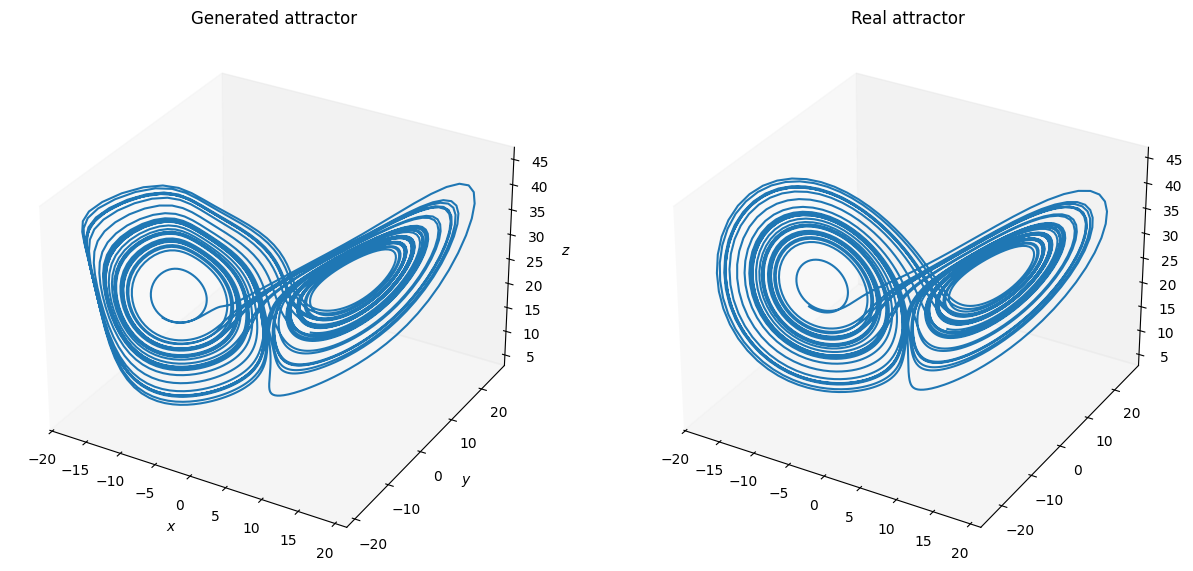

In [21]:
# finally, predict the model with the test data

outputs = trainer.predict(X_test)
print('Prediction NMS: ', bp.losses.mean_squared_error(outputs, Y_test))
plot_lorenz(bm.as_numpy(Y_test).squeeze(), bm.as_numpy(outputs).squeeze())

## Switch different training algorithms

``brainpy.OfflineTrainer`` supports easy switch of training algorithms. You just need provide the ``fit_method`` argument when instantiating an offline trainer.

Many offline algorithms, like linear regression, ridge regression, and Lasso regression, have been provided as the build-in models.

  0%|          | 0/495 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

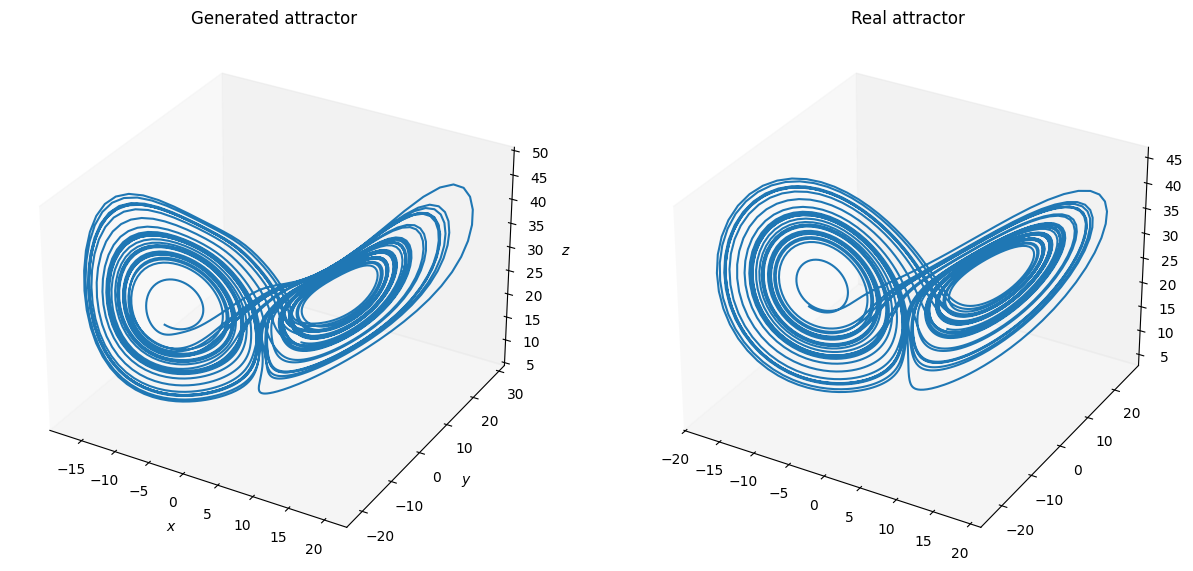

In [22]:
model = ESN(3, 100, 3)
model.reset(1)
trainer = bp.OfflineTrainer(model, fit_method=bp.algorithms.LinearRegression())

_ = trainer.predict(X_warmup)
_ = trainer.fit([X_train, Y_train])
outputs = trainer.predict(X_test)
plot_lorenz(bm.as_numpy(Y_test).squeeze(), bm.as_numpy(outputs).squeeze())

## Customize your training algorithms

``brainpy.OfflineTrainer`` also supports to train models with your customized training algorithms.

Specifically, the customization of an offline algorithm should follow the interface of ``brainpy.algorithms.OfflineAlgorithm``, in which users specify how the model parameters are calculated according to the input, prediction, and target data.

For instance, here we use the ``Lasso`` model provided in scikit-learn package to define an offline training algorithm.

In [23]:
from sklearn.linear_model import Lasso

class LassoAlgorithm(bp.algorithms.OfflineAlgorithm):
  def __init__(self, alpha=1., max_iter=int(1e4)):
    super(LassoAlgorithm, self).__init__()
    self.model = Lasso(alpha=alpha, max_iter=max_iter)

  def __call__(self, y, x, outs=None):
    x = bm.as_numpy(x[0])
    y = bm.as_numpy(y[0])
    x_new = self.model.fit(x, y).coef_.T
    return bm.expand_dims(bm.asarray(x_new), 1)

  0%|          | 0/495 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

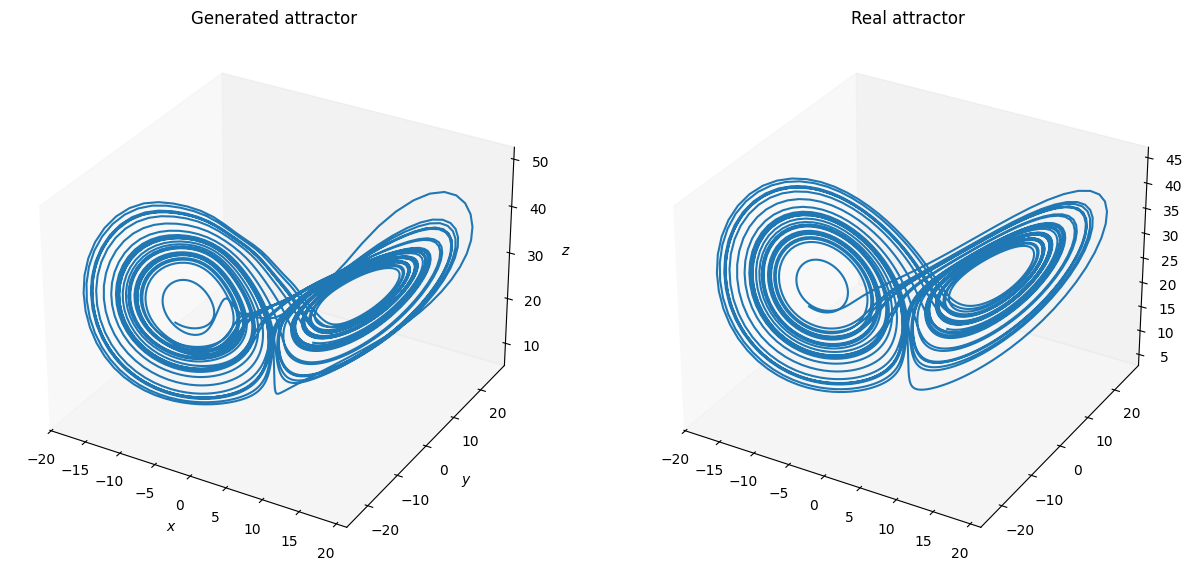

In [24]:
model = ESN(3, 100, 3)
model.reset_state(1)

# note here scikit-learn algorithms does not support JAX jit,
# therefore the "jit" of the "fit" phase is set to be False.
trainer = bp.OfflineTrainer(model,
                            fit_method=bp.algorithms.LinearRegression(),
                            jit={'fit': False})

_ = trainer.predict(X_warmup)
_ = trainer.fit([X_train, Y_train])
outputs = trainer.predict(X_test)
plot_lorenz(bm.as_numpy(Y_test).squeeze(), bm.as_numpy(outputs).squeeze())